# Demo: Predicting Citibike Trips Using Snowflake & Facebook Prophet

***IMPORTANT: Make sure to restart the kernel before you move forward***

In [2]:
from snowflake.snowpark import Session
import pandas as pd
from fbprophet import Prophet
import sys

### 1. Load the Credentials


In [1]:
import json

with open('creds.json') as f:
    connection_parameters = json.load(f)    

### 2. Load data
We first create a connection to our Snowflake account by specifying the auth details as well as the DB, schema and warehouse we want to use.

The first step in using the library is establishing a session with the Snowflake database.

In [3]:
session = Session.builder.configs(connection_parameters).create()

Print the connection details

In [4]:
print(session.sql("select current_warehouse(), current_database(), current_schema()").collect())  

[Row(CURRENT_WAREHOUSE()='LOAD_WH', CURRENT_DATABASE()='CITIBIKE', CURRENT_SCHEMA()='DEMO')]


Lets summarize trips to daily resolution and inspect the first five rows

In [5]:
output = session.sql("SELECT date_trunc('day', STARTTIME), count(*) FROM trips_vw" + \
        " GROUP BY date_trunc('day', STARTTIME)" +\
        " ORDER BY date_trunc('day', STARTTIME)")

Preview the data

In [6]:
output.show()

-----------------------------------------------
|"DATE_TRUNC('DAY', STARTTIME)"  |"COUNT(*)"  |
-----------------------------------------------
|2013-06-03 00:00:00             |3530        |
|2013-06-04 00:00:00             |4058        |
|2013-06-05 00:00:00             |4329        |
|2013-06-06 00:00:00             |4366        |
|2013-06-07 00:00:00             |4260        |
|2013-06-08 00:00:00             |4405        |
|2013-06-09 00:00:00             |3874        |
|2013-06-10 00:00:00             |3999        |
|2013-06-11 00:00:00             |4652        |
|2013-06-12 00:00:00             |4954        |
-----------------------------------------------



Count the number of aggregated records 

In [7]:
output.count()

3200

For simplicity, let's convert our result to a pandas dataframe, to be able to use our favorite ML libs

In [8]:
# Convert the results to a pandas dataframe
output_df = output.toPandas()

In [11]:
# # The FB Prophet library expects the data to be in two columns: 'ds' for timestamp and 'y' for the value

output_df.columns =['ds', 'y']
output_df.head()

,ds,y
0,2013-06-03,3530
1,2013-06-04,4058
2,2013-06-05,4329
3,2013-06-06,4366
4,2013-06-07,4260


The Facebook Prophet library [https://facebook.github.io/prophet/] expects two columns as input: `ds` (timestamp) and `y` (the value we are trying to predict).

Lets look at how many total records we have at the daily interval:

In [24]:
output_df.count()

ds    3200
y     3200
dtype: int64

### 3. Train the model

Now that we have the data in the right format, lets train our time series model using Facebook Prophet:

In [13]:
m = Prophet()
m.fit(output_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -287.512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5818.53    0.00566664       222.612      0.3782           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5835.96    0.00528212       109.506      0.2568           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209        5836.2   0.000188361       102.502   1.206e-06       0.001      289  LS failed, Hessian reset 
     299       5839.59   0.000192639       111.187   1.799e-06       0.001      446  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       5840.63   0.000104064       79.6461   1.556e-06       0.001      609  LS failed, Hessian reset 
     399       5840.65   9.48157e-05       76.3449      0.3026           1      618 

### 4. Inference & Visualization

Using a FB Prophet helper function, lets create a dataframe that will hold our predictions and then make predictions for the next two years.

In [14]:
future = m.make_future_dataframe(periods=730)
future.tail()

,ds
3925,2024-03-02
3926,2024-03-03
3927,2024-03-04
3928,2024-03-05
3929,2024-03-06


In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3925,2024-03-02,23659.074119,19034.645215,28291.023557
3926,2024-03-03,22457.953279,18049.046959,27318.487760
3927,2024-03-04,21498.768208,17034.917417,26174.810817
3928,2024-03-05,23303.909532,18330.938580,28138.064860
3929,2024-03-06,24215.896208,19538.795716,29047.022550


We will now plot the forecast along with our historical data

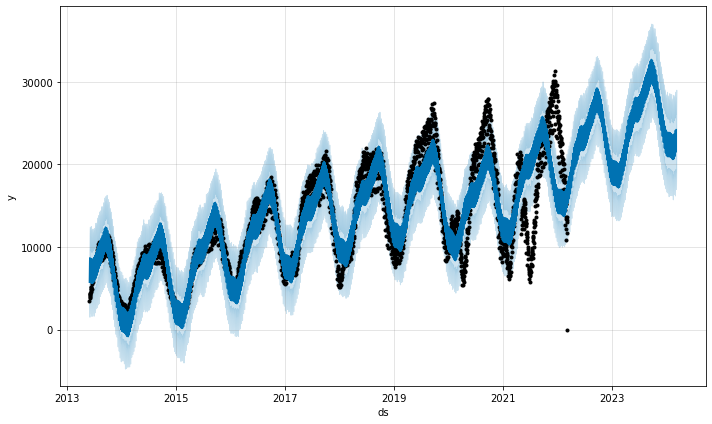

In [16]:
fig1 = m.plot(forecast)

To see the seasonality of the data, lets plot the components that will show how our data changes yearly, weekly and its overall trend.

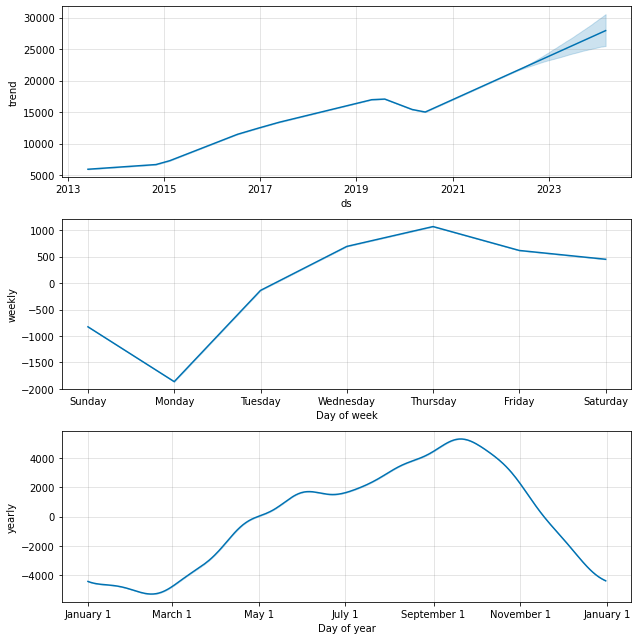

In [17]:
fig2 = m.plot_components(forecast)

### 4. Write the predictions back into Snowflake

Convert our results back to a snowflake dataframe

In [22]:
final_df = session.create_dataframe(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

INFO:snowflake.connector.cursor:query: [create temporary stage /* Python:snowflake.connector.pandas_tools.write_pandas()...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [PUT /* Python:snowflake.connector.pandas_tools.write_pandas() */ 'file:///var/fo...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [CREATE FILE FORMAT "kzefl" /* Python:snowflake.connector.pandas_tools.write_pand...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SELECT COLUMN_NAME, TYPE FROM table(infer_schema(location=>'@"apytd"', file_form...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [CREATE TEMP TABLE IF NOT EXISTS "CITIBIKE"."DEMO"."SNOWPARK_TEMP_TABLE_RBJQQJ4WJ...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [DROP FILE FORMAT IF EXISTS "kzefl"]
INFO:snowflake.connector.cursor:qu

In [20]:
final_df.count()

INFO:snowflake.connector.cursor:query: [SELECT  *  FROM ("CITIBIKE"."DEMO"."SNOWPARK_TEMP_TABLE_XQHKL58GNC")]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SELECT count(1) AS "COUNT(LITERAL())" FROM ( SELECT  *  FROM ("CITIBIKE"."DEMO"....]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01a3477a-3201-0df4-0001-198e0004e17e]  SELECT count(1) AS "COUNT(LITERAL())" FROM ( SELECT  *  FROM ("CITIBIKE"."DEMO"."SNOWPARK_TEMP_TABLE_XQHKL58GNC")) LIMIT 1


3930

Write the results back into the initial database

In [23]:
final_df.write.mode("overwrite").save_as_table("TRIPS_FORECAST")

INFO:snowflake.connector.cursor:query: [CREATE  OR  REPLACE  TABLE  TRIPS_FORECAST AS  SELECT  *  FROM ( SELECT  *  FROM...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01a3477f-3201-0df4-0001-198e0004e1aa]  CREATE  OR  REPLACE  TABLE  TRIPS_FORECAST AS  SELECT  *  FROM ( SELECT  *  FROM ("CITIBIKE"."DEMO"."SNOWPARK_TEMP_TABLE_RBJQQJ4WJV"))


Close the session

In [25]:
session.close()

INFO:snowflake.snowpark.session:Closing session: 309572654129194
INFO:snowflake.snowpark.session:Canceling all running queries
INFO:snowflake.connector.cursor:query: [select system$cancel_all_queries(309572654129194)]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.snowpark._internal.server_connection:Execute query [queryID: 01a34787-3201-0df5-0001-198e00052052] select system$cancel_all_queries(309572654129194)
INFO:snowflake.connector.connection:closed
INFO:snowflake.connector.connection:No async queries seem to be running, deleting session
INFO:snowflake.snowpark.session:Closed session: 309572654129194
